<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Sequence_Sentiment_Classification/sequence_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Sentiment Classification with LLMs

In [ ]:
#============================
# Setup and Installation
#============================

In [ ]:
!pip install huggingface_hub[hf_xet]==0.36.0 &> /dev/null

In [ ]:
!pip install openai -q &> /dev/null

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import Dataset
from sklearn.metrics import precision_recall_fscore_support
from datasets import Dataset as HFDataset
from collections import Counter
import re
from datetime import datetime
from wordcloud import WordCloud
from openai import OpenAI
import os
from tqdm import tqdm
import time
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

stop_words = set(stopwords.words('english'))




In [ ]:
#===================================
# Data Loading and Preparation
#===================================

In [ ]:
# Path of the dataset
csv_path = "/content/sentiment_.csv"
df = pd.read_csv(csv_path, usecols=["target", "date", "text"])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  11000 non-null  int64 
 1   date    11000 non-null  object
 2   text    11000 non-null  object
dtypes: int64(1), object(2)
memory usage: 257.9+ KB


In [ ]:
df.head()

,target,date,text
0,0,Thu Jun 25 07:33:26 PDT 2009,Work is slow!
1,0,Thu Jun 25 07:33:27 PDT 2009,At work studying :-/ I want to enjoy this radi...
2,0,Thu Jun 25 07:33:30 PDT 2009,@katiedollfacexo I hate the dentist
3,0,Thu Jun 25 07:33:30 PDT 2009,Ok atl I thought new york had some killer pige...
4,0,Thu Jun 25 07:33:31 PDT 2009,Eeef am missing show 2nite Feel crappier than...


In [ ]:
# Map numeric labels to textual sentiment labels
label_map_num2str = {
    0: "negative",
    1: "positive"
}
df = df[df["target"].isin(label_map_num2str.keys())].copy()
df["label_str"] = df["target"].map(label_map_num2str)

# Use both date and text (zero-shot model only sees text, so we inject date as context)
df["input_text"] = df.apply(
    lambda row: f"On {row['date']}, the user tweeted: {row['text']}",
    axis=1
)


# Train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=0,
    stratify=df["label_str"],
    shuffle=True
)

print(train_df.shape, test_df.shape)


(8800, 5) (2200, 5)


In [ ]:
#===================================
# EDA
#===================================

SENTIMENT DISTRIBUTION ANALYSIS

Total samples: 11000

Sentiment Counts:
  Positive  :   6000 (54.55%)
  Negative  :   5000 (45.45%)


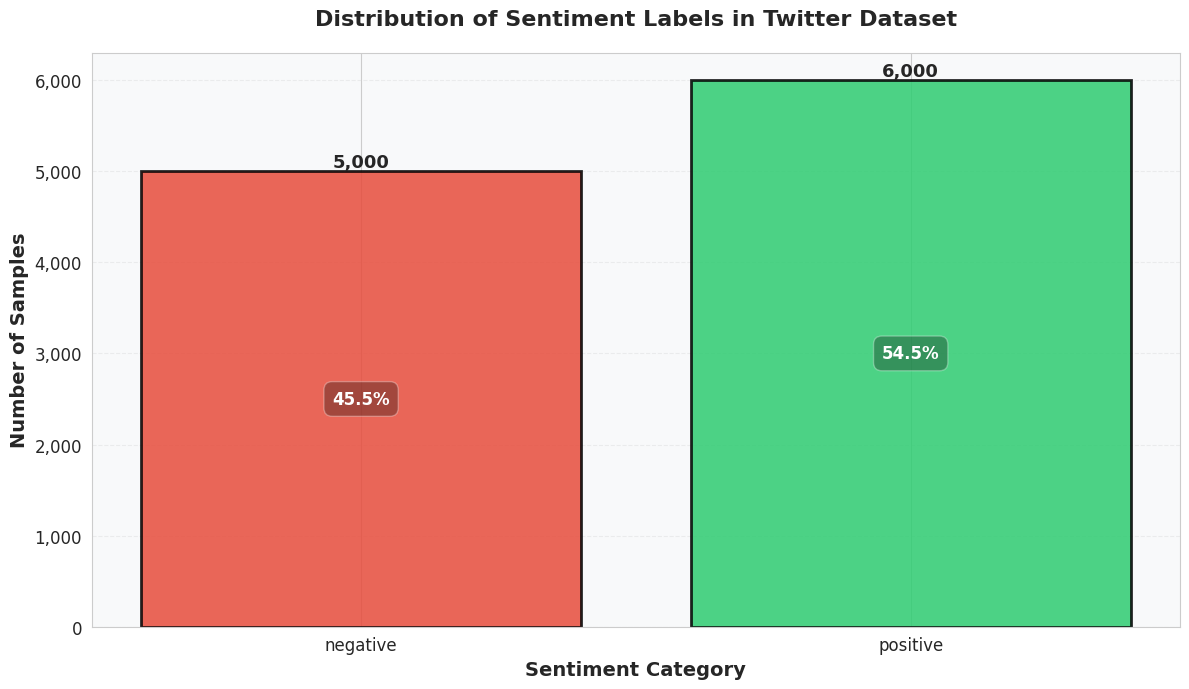

In [ ]:

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Count the sentiments
sentiment_counts = df["label_str"].value_counts()

print("=" * 50)
print("SENTIMENT DISTRIBUTION ANALYSIS")
print("=" * 50)
print(f"\nTotal samples: {len(df)}")
print("\nSentiment Counts:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {sentiment.capitalize():<10}: {count:>6} ({percentage:>5.2f}%)")
print("=" * 50)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors
colors = {
    'negative': '#e74c3c',  # red
    'positive': '#2ecc71'   # green
}

# Ensure order
ordered_sentiments = ['negative', 'positive']
ordered_counts = [sentiment_counts.get(s, 0) for s in ordered_sentiments]
ordered_colors = [colors[s] for s in ordered_sentiments]

# Create bars
bars = ax.bar(ordered_sentiments, ordered_counts, color=ordered_colors,
              alpha=0.85, edgecolor='black', linewidth=2)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Add percentage labels inside bars
total = sum(ordered_counts)
for i, (sentiment, count) in enumerate(zip(ordered_sentiments, ordered_counts)):
    if count > 0:
        percentage = (count / total) * 100
        ax.text(i, count/2, f'{percentage:.1f}%',
                ha='center', va='center', fontsize=12,
                color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.3))

# Styling
ax.set_xlabel('Sentiment Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Sentiment Labels in Twitter Dataset',
             fontsize=16, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Format y-axis to show comma-separated thousands
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add a subtle background color
ax.set_facecolor('#f8f9fa')

plt.tight_layout()

plt.show()

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"\nSentiment distribution:")
print(df['target'].value_counts())
print(f"\nNegative (0): {(df['target']==0).sum()}")
print(f"Positive (1): {(df['target']==1).sum()}")

Dataset Overview:
Total samples: 11000

Sentiment distribution:
target
1    6000
0    5000
Name: count, dtype: int64

Negative (0): 5000
Positive (1): 6000


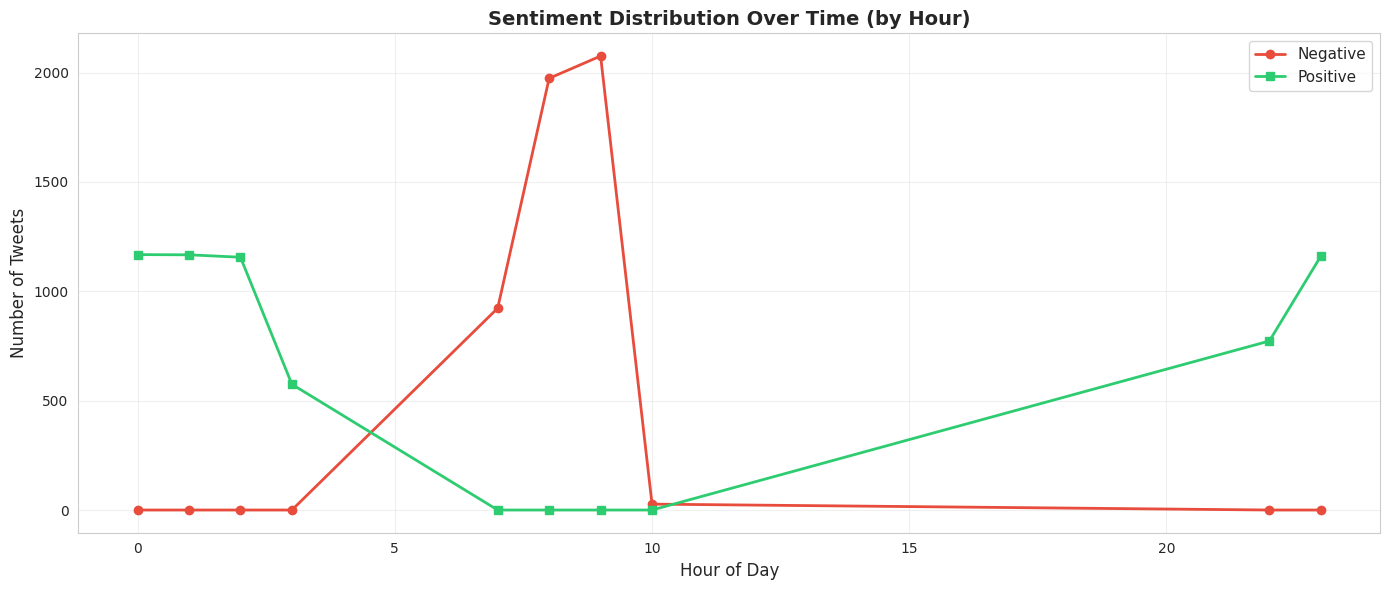


Tweets by hour:
target     0     1
hour              
0          0  1168
1          0  1167
2          0  1156
3          0   575
7        923     0
8       1974     0
9       2076     0
10        27     0
22         0   773
23         0  1161


In [ ]:
# Parse dates
def parse_twitter_date(date_str):
    try:
        return datetime.strptime(date_str, '%a %b %d %H:%M:%S PDT %Y')
    except:
        return None

df['parsed_date'] = df['date'].apply(parse_twitter_date)
df['hour'] = df['parsed_date'].dt.hour
df['day'] = df['parsed_date'].dt.day

# Sentiment over time (by hour)
sentiment_by_hour = df.groupby(['hour', 'target']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
plt.plot(sentiment_by_hour.index, sentiment_by_hour[0], marker='o', linewidth=2, label='Negative', color='#e74c3c')
plt.plot(sentiment_by_hour.index, sentiment_by_hour[1], marker='s', linewidth=2, label='Positive', color='#2ecc71')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.title('Sentiment Distribution Over Time (by Hour)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTweets by hour:")
print(sentiment_by_hour)

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Preprocess all texts
df['tokens'] = df['text'].apply(preprocess_text)
print("Text preprocessing complete!")
print(f"\nExample original text: {df['text'].iloc[0]}")
print(f"Preprocessed tokens: {df['tokens'].iloc[0]}")

Text preprocessing complete!

Example original text: Work is slow! 
Preprocessed tokens: ['work', 'slow']


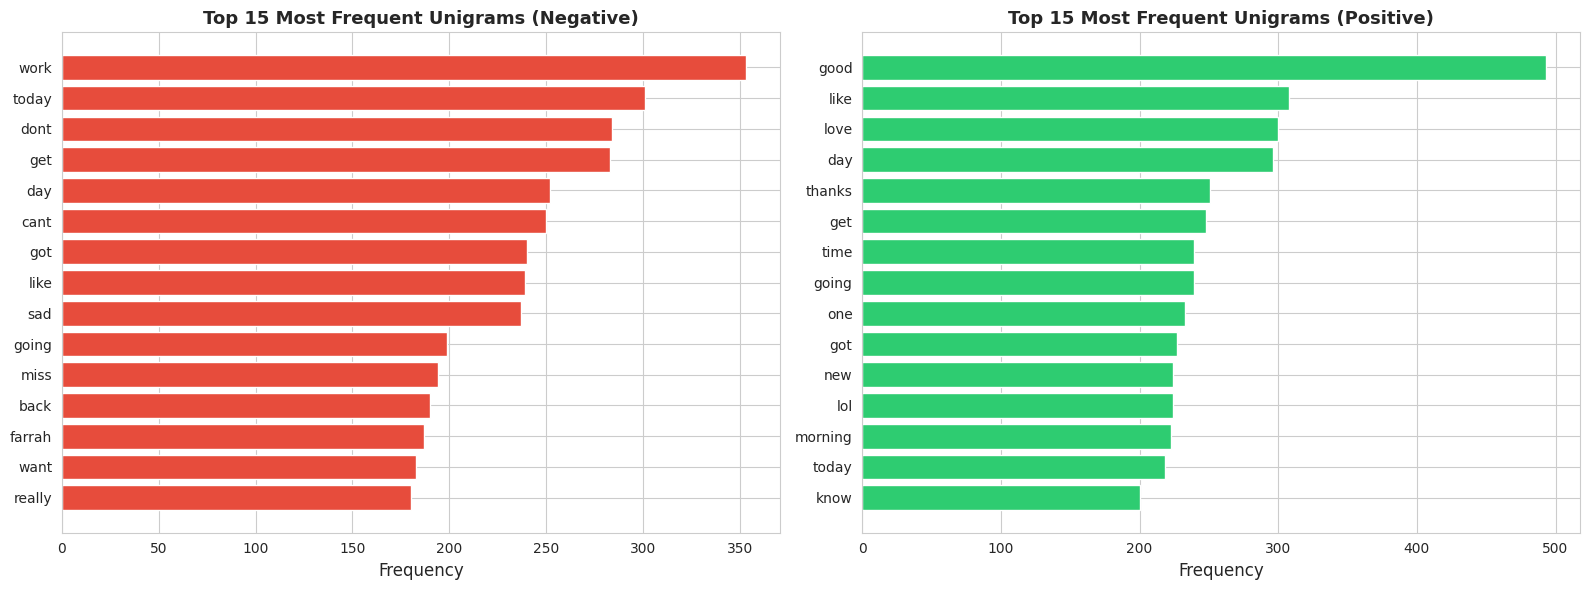


Top 10 Negative Unigrams:
  work: 353
  today: 301
  dont: 284
  get: 283
  day: 252
  cant: 250
  got: 240
  like: 239
  sad: 237
  going: 199

Top 10 Positive Unigrams:
  good: 493
  like: 308
  love: 300
  day: 296
  thanks: 251
  get: 248
  time: 239
  going: 239
  one: 233
  got: 227


In [ ]:
# Get all tokens for negative and positive sentiments
negative_tokens = [token for tokens in df[df['target']==0]['tokens'] for token in tokens]
positive_tokens = [token for tokens in df[df['target']==1]['tokens'] for token in tokens]

# Most frequent unigrams
negative_unigrams = Counter(negative_tokens).most_common(20)
positive_unigrams = Counter(positive_tokens).most_common(20)

# Create bigrams
def get_bigrams(tokens_list):
    bigrams = []
    for tokens in tokens_list:
        if len(tokens) > 1:
            bigrams.extend([f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)])
    return bigrams

negative_bigrams = Counter(get_bigrams(df[df['target']==0]['tokens'])).most_common(20)
positive_bigrams = Counter(get_bigrams(df[df['target']==1]['tokens'])).most_common(20)

# Plot most frequent unigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Negative unigrams
words, counts = zip(*negative_unigrams[:15])
axes[0].barh(words, counts, color='#e74c3c')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Most Frequent Unigrams (Negative)', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Positive unigrams
words, counts = zip(*positive_unigrams[:15])
axes[1].barh(words, counts, color='#2ecc71')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Most Frequent Unigrams (Positive)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 10 Negative Unigrams:")
for word, count in negative_unigrams[:10]:
    print(f"  {word}: {count}")

print("\nTop 10 Positive Unigrams:")
for word, count in positive_unigrams[:10]:
    print(f"  {word}: {count}")

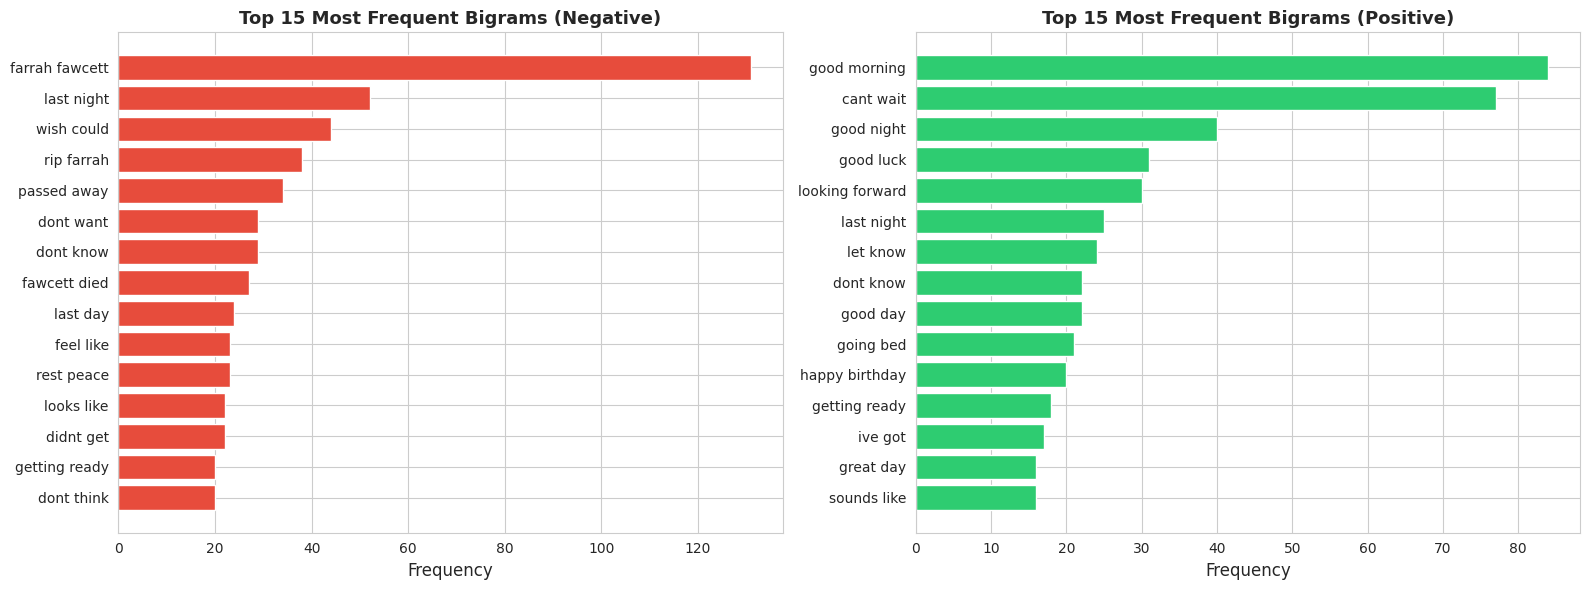


Top 10 Negative Bigrams:
  'farrah fawcett': 131
  'last night': 52
  'wish could': 44
  'rip farrah': 38
  'passed away': 34
  'dont want': 29
  'dont know': 29
  'fawcett died': 27
  'last day': 24
  'feel like': 23

Top 10 Positive Bigrams:
  'good morning': 84
  'cant wait': 77
  'good night': 40
  'good luck': 31
  'looking forward': 30
  'last night': 25
  'let know': 24
  'dont know': 22
  'good day': 22
  'going bed': 21


In [ ]:
# Plot most frequent bigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Negative bigrams
bigrams, counts = zip(*negative_bigrams[:15])
axes[0].barh(bigrams, counts, color='#e74c3c')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Most Frequent Bigrams (Negative)', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Positive bigrams
bigrams, counts = zip(*positive_bigrams[:15])
axes[1].barh(bigrams, counts, color='#2ecc71')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Most Frequent Bigrams (Positive)', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 10 Negative Bigrams:")
for bigram, count in negative_bigrams[:10]:
    print(f"  '{bigram}': {count}")

print("\nTop 10 Positive Bigrams:")
for bigram, count in positive_bigrams[:10]:
    print(f"  '{bigram}': {count}")

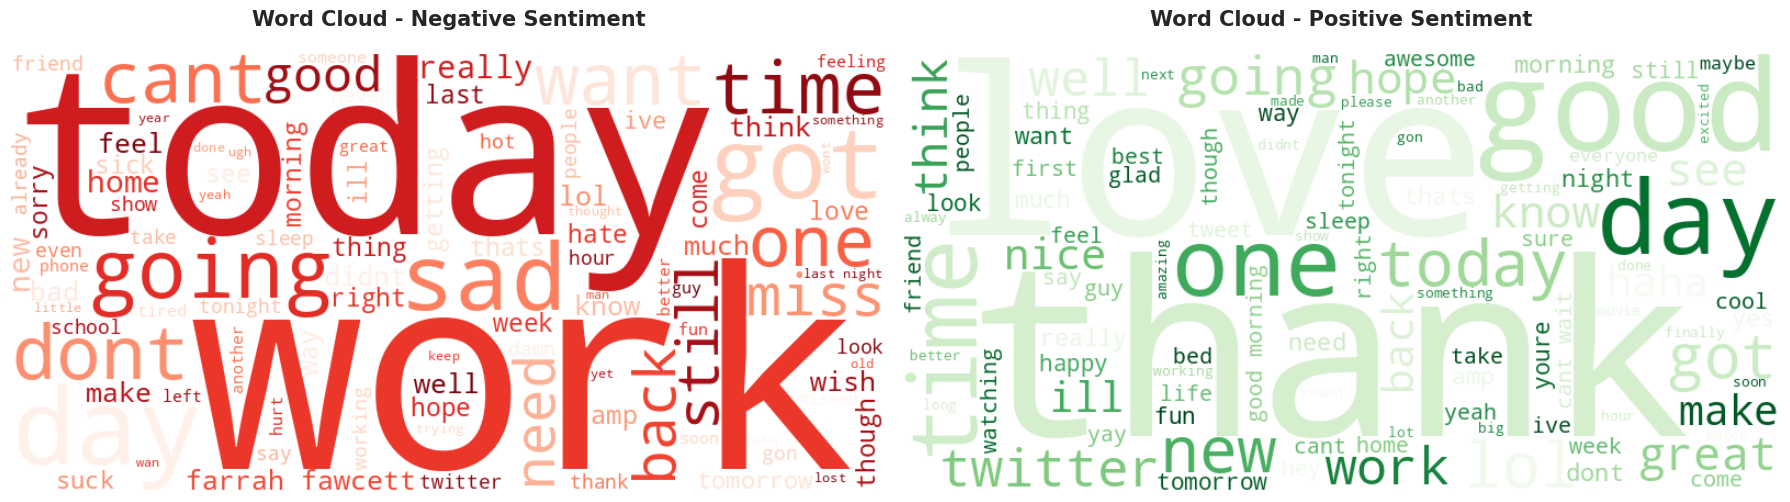


Word clouds generated successfully!


In [ ]:
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Negative sentiment wordcloud
negative_text = ' '.join(negative_tokens)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(negative_text)
axes[0].imshow(wordcloud_neg, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - Negative Sentiment', fontsize=15, fontweight='bold', pad=20)

# Positive sentiment wordcloud
positive_text = ' '.join(positive_tokens)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(positive_text)
axes[1].imshow(wordcloud_pos, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - Positive Sentiment', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\nWord clouds generated successfully!")

In [ ]:
#=======================================================
# BERT Model Training & Evaluation
#=======================================================

In [ ]:
candidate_labels = ["negative", "positive"]
label_map_str2num = {"negative": 0, "positive": 1}

# Map string labels to numeric for training
train_df["label"] = train_df["label_str"].map(label_map_str2num)
test_df["label"] = test_df["label_str"].map(label_map_str2num)

print("Label distribution in train set:")
print(train_df["label_str"].value_counts())
print("\nLabel distribution in test set:")
print(test_df["label_str"].value_counts())


Label distribution in train set:
label_str
positive    4800
negative    4000
Name: count, dtype: int64

Label distribution in test set:
label_str
positive    1200
negative    1000
Name: count, dtype: int64


In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Choose a pre-trained model optimized for sentiment analysis
model_name = "bert-base-uncased"
# Alternative options:
# model_name = "distillbert-base-uncased"
# model_name = "roberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Loaded tokenizer: {model_name}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loaded tokenizer: bert-base-uncased


In [ ]:
# Function to tokenize texts
def tokenize_function(examples):
    """
    Tokenize the text data.
    This function is applied to the dataset using map().
    """
    return tokenizer(
        examples["input_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Convert pandas DataFrames to HuggingFace Dataset format
print("Creating HuggingFace datasets...")
train_hf_dataset = HFDataset.from_pandas(train_df[["input_text", "label"]])
test_hf_dataset = HFDataset.from_pandas(test_df[["input_text", "label"]])

# Apply tokenization
print("Tokenizing datasets...")
train_dataset = train_hf_dataset.map(tokenize_function, batched=True)
test_dataset = test_hf_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Rename 'label' to 'labels' (required by Trainer)
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"\nDataset columns: {train_dataset.column_names}")


Creating HuggingFace datasets...
Tokenizing datasets...


Map:   0%|          | 0/8800 [00:00<?, ? examples/s]

Map:   0%|          | 0/2200 [00:00<?, ? examples/s]


Train dataset size: 8800
Test dataset size: 2200

Dataset columns: ['input_text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # negative, positive
    problem_type="single_label_classification"
)

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define compute metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate F1 scores
    f1_macro = f1_score(labels, preds, average='macro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    f1_micro = f1_score(labels, preds, average='micro')

    # Calculate accuracy
    accuracy = (preds == labels).mean()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro
    }


In [ ]:
# Training arguments
training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

print("Training configuration:")
print(f"  - Epochs: {training_args.num_train_epochs}")
print(f"  - Train batch size: {training_args.per_device_train_batch_size}")
print(f"  - Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Weight decay: {training_args.weight_decay}")
print(f"  - FP16: {training_args.fp16}")


Training configuration:
  - Epochs: 5
  - Train batch size: 16
  - Eval batch size: 32
  - Learning rate: 5e-05
  - Weight decay: 0.01
  - FP16: True


In [ ]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Trainer initialized successfully!")
print("\nStarting training...\n")


Trainer initialized successfully!

Starting training...



In [ ]:
# Train the model
train_result = trainer.train()

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples per second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 Micro
1,0.000100,0.000043,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000013,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000007,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000006,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000005,1.000000,1.000000,1.000000,1.000000



TRAINING COMPLETED!
Training time: 210.56 seconds
Training samples per second: 208.97
Final training loss: 0.0155


In [ ]:
# Evaluate the model
print("\nEvaluating model on test set...\n")
eval_results = trainer.evaluate()

print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Test Loss:          {eval_results['eval_loss']:.4f}")
print(f"Test Accuracy:      {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score (Macro):   {eval_results['eval_f1_macro']:.4f}")
print(f"F1 Score (Weighted):{eval_results['eval_f1_weighted']:.4f}")
print(f"F1 Score (Micro):   {eval_results['eval_f1_micro']:.4f}")
print("="*60)



Evaluating model on test set...



EVALUATION RESULTS
Test Loss:          0.0000
Test Accuracy:      1.0000
F1 Score (Macro):   1.0000
F1 Score (Weighted):1.0000
F1 Score (Micro):   1.0000


In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = test_df["label"].values

# Map numeric predictions back to string labels
label_map_num2str_new = {0: "negative", 1: "positive"}
test_df["predicted"] = [label_map_num2str_new[p] for p in y_pred]

print(f"Generated predictions for {len(y_pred)} samples")


Generated predictions for 2200 samples


In [ ]:
# Detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_true,
    y_pred,
    target_names=candidate_labels,
    digits=4
))
print("="*60)



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000      1000
    positive     1.0000    1.0000    1.0000      1200

    accuracy                         1.0000      2200
   macro avg     1.0000    1.0000    1.0000      2200
weighted avg     1.0000    1.0000    1.0000      2200



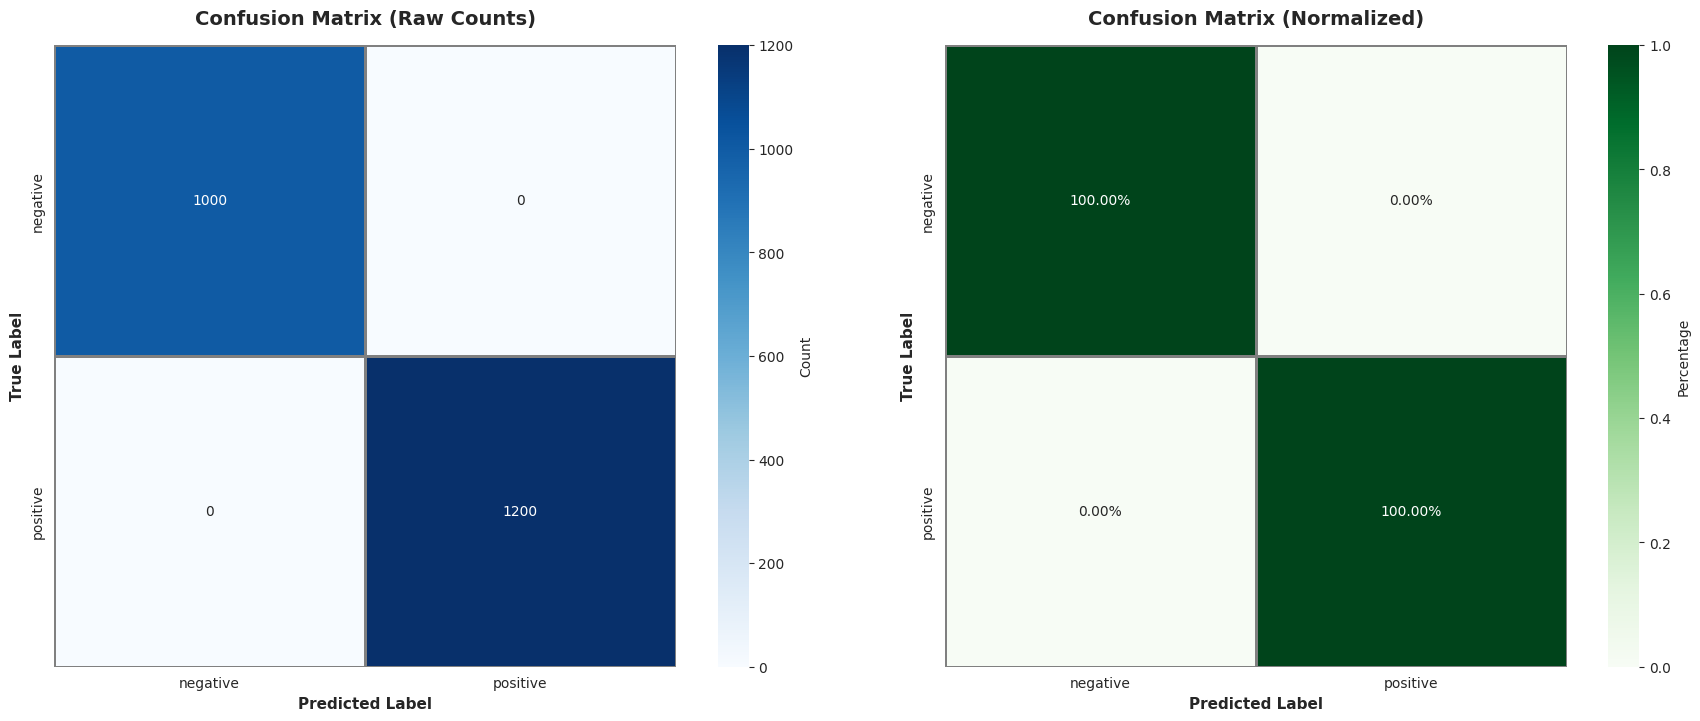


Confusion Matrix (raw counts):
[[1000    0]
 [   0 1200]]

Confusion Matrix (normalized):
[[1. 0.]
 [0. 1.]]


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
    cbar_kws={'label': 'Count'},
    square=True,
    linewidths=1,
    linecolor='gray',
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

# Plot 2: Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
    cbar_kws={'label': 'Percentage'},
    square=True,
    linewidths=1,
    linecolor='gray',
    ax=axes[1]
)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix (raw counts):")
print(cm)
print("\nConfusion Matrix (normalized):")
print(cm_normalized)


In [ ]:
#======================================
# GPT-4o-mini Zero-Shot Classification
#======================================

In [ ]:
root_folder="/content/"
_ = load_dotenv(root_folder + "openai.env")
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))


In [ ]:

def predict_sentiment_gpt(text, max_retries=3, retry_delay=1):
    """
    Predict sentiment using GPT-4o-mini zero-shot classification.
    Returns 0 for negative, 1 for positive.
    """
    prompt = f"""Analyze the sentiment of the following text and respond with only 'positive' or 'negative'.

Text: {text}

Sentiment:"""

    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a sentiment analysis assistant. Respond only with 'positive' or 'negative'."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                max_tokens=10
            )

            sentiment = response.choices[0].message.content.strip().lower()

            if 'positive' in sentiment:
                return 1
            elif 'negative' in sentiment:
                return 0
            else:
                # If unclear, try again
                if attempt < max_retries - 1:
                    time.sleep(retry_delay)
                    continue
                # Default to negative if all retries fail
                return 0

        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
            else:
                # Return default value if all retries fail
                return 0

    return 0

print("GPT-4o-mini prediction function defined.")
print("\nTesting with a sample text...")
sample_text = "I love this amazing product! It works perfectly."
result = predict_sentiment_gpt(sample_text)
print(f"Sample text: '{sample_text}'")
print(f"Predicted sentiment: {'Positive' if result == 1 else 'Negative'}")

GPT-4o-mini prediction function defined.

Testing with a sample text...
Sample text: 'I love this amazing product! It works perfectly.'
Predicted sentiment: Positive


In [ ]:
# Get test dataset
# Note: Assuming test_df was created in previous cells
# If not, create it from the original df

print(f"Running GPT-4o-mini predictions on {len(test_df)} test samples...")
print("This may take several minutes depending on API rate limits.\n")

# Predict sentiments using GPT-4o-mini
gpt_predictions = []

# Use tqdm for progress bar
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="GPT-4o-mini predictions"):
    text = row['input_text']
    prediction = predict_sentiment_gpt(text)
    gpt_predictions.append(prediction)

    # Add a small delay to respect rate limits
    time.sleep(0.1)

# Convert to numpy array
gpt_predictions = np.array(gpt_predictions)
true_labels = test_df['target'].values

print(f"\nCompleted {len(gpt_predictions)} predictions.")

Running GPT-4o-mini predictions on 2200 test samples...
This may take several minutes depending on API rate limits.



GPT-4o-mini predictions: 100%|██████████| 2200/2200 [27:56<00:00,  1.31it/s]


Completed 2200 predictions.


In [ ]:
# Detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_labels, gpt_predictions,
                          target_names=['Negative', 'Positive'],
                          digits=4))
print("="*60)



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.7104    0.8170    0.7600      1000
    Positive     0.8257    0.7225    0.7707      1200

    accuracy                         0.7655      2200
   macro avg     0.7681    0.7697    0.7653      2200
weighted avg     0.7733    0.7655    0.7658      2200



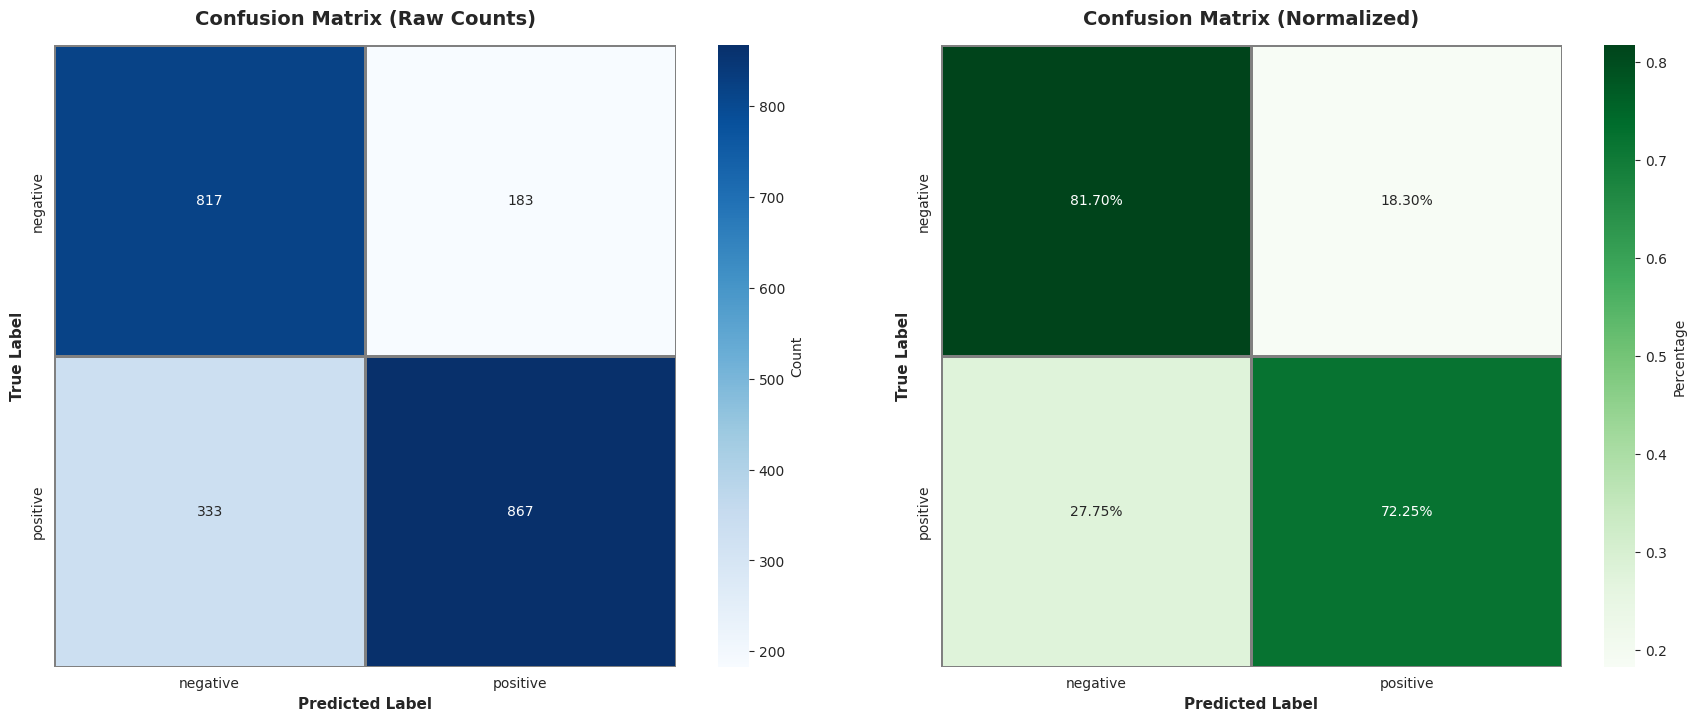


Confusion Matrix (raw counts):
[[1000    0]
 [   0 1200]]

Confusion Matrix (normalized):
[[0.817  0.183 ]
 [0.2775 0.7225]]


In [ ]:
# Calculate confusion matrix
cm_gpt = confusion_matrix(true_labels, gpt_predictions)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(
    cm_gpt,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
    cbar_kws={'label': 'Count'},
    square=True,
    linewidths=1,
    linecolor='gray',
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

# Plot 2: Normalized (percentages)
cm_normalized = cm_gpt.astype('float') / cm_gpt.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
    cbar_kws={'label': 'Percentage'},
    square=True,
    linewidths=1,
    linecolor='gray',
    ax=axes[1]
)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix (raw counts):")
print(cm)
print("\nConfusion Matrix (normalized):")
print(cm_normalized)
